# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
import arabicstopwords.arabicstopwords as stp
from keras.preprocessing.sequence import pad_sequences
import re
import os
from camel_tools.tokenizers.word import simple_word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
import random
import emoji
import qalsadi.lemmatizer
from wordcloud import WordCloud
import plotly.express as px
import arabic_reshaper
from bidi.algorithm import get_display
from plotly import graph_objects as go
from collections import Counter
import string
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
random.seed(10)

In [2]:
colors1 = ['#c7dd93','#b7d374']
colors2 = ['#e0ebc8', '#c8db9c']
color3 = ['Salmon', 'FireBrick', 'MediumVioletRed', 'Tomato', 'Orange', 'Gold', 'DarkKhaki', 'Lavender', 'Plum', 'LimeGreen', 'MediumSpringGreen', 'Green', 'DeepSkyBlue', 'Aquamarine', 'MediumSlateBlue']

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [5]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.drop('clean_txt', axis=1, inplace=True)
Corpus.rename(columns={'sentiment': 'Sentiment', 'txt': 'Text'}, inplace=True)
Corpus

,Sentiment,Text
0,Positive,بالنسبالي دي احسن رواية كتبها احمد مراد
1,Negative,الرواية ممتعة (كأحداث) ولكن يعيبها ما يلي : 1-...
2,Positive,كتآب أنيق ف حسب .
3,Negative,مش مقتنعه بصراحه بالجو بتاعه ده:)
4,Negative,قرأت 100 ورقة ووقفت . كلام تقيل جدًا ومش فاهمه...
...,...,...
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...


# Percantage Of Each Sentiment

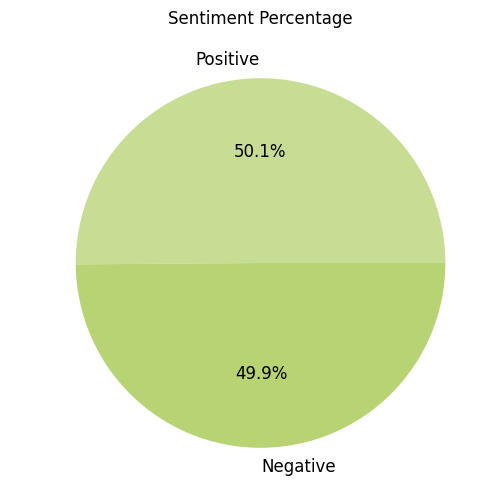

In [6]:
Corpus['Sentiment'].value_counts().plot.pie(autopct = '%0.1f%%',
                                                    textprops = {'size': 'large'},
                                                    title = 'Sentiment Percentage',
                                                    figsize = (6,6),
                                                    colors = colors1,
                                                    ylabel = ' ');

# Count Of Each Sentiment

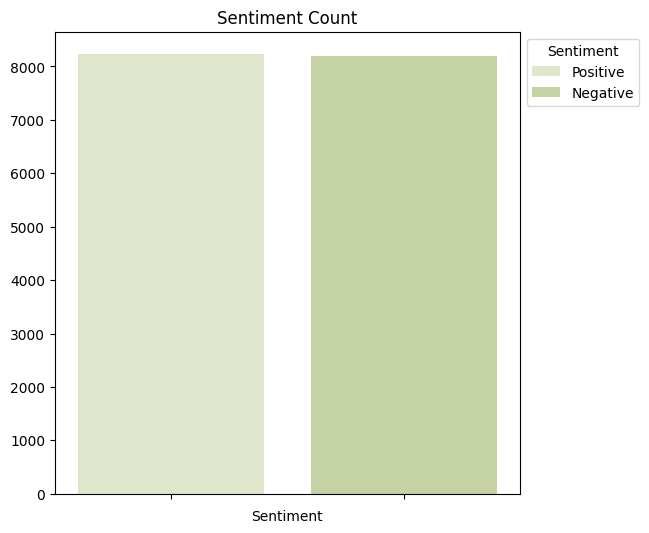

In [7]:
ax, fig = plt.subplots(figsize = (6,6))
ax =sns.countplot(x='Sentiment', data=Corpus, dodge=False, hue='Sentiment',  order= Corpus['Sentiment'].value_counts().index, hue_order =Corpus['Sentiment'].value_counts().index,  palette=colors2);
ax.set(xticklabels=[]) 
ax.set(ylabel=None) 
plt.title('Sentiment Count')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Text'].apply(lambda n:len(nltk.tokenize.sent_tokenize(n)))
Corpus.drop(Corpus[ Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Text Normalization

In [12]:
def remove_emojis(text):
     "Remove All Emojis From Text"
     text = emoji.replace_emoji(text, replace="")
     return text

def remove_hashtags(text):
     "Remove All Hashtags From Text"
     text =  re.sub("#[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text   

def remove_emails(text):
     "Remove All Emails From Text"
     text = re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z]+.[a-zA-Z]+","", text)  
     return text    

def remove_url(text):
     "Remove All URL From Text"
     text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
     return text

def remove_mention(text):
     "Remove All Mention From Text"
     text = re.sub("@[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text

def remove_duplicate_char(text):
     "Remove Chars Word Has More Than 2 Same Following Char"
     text = re.sub(r'(.)\1+', r'\1\1', text)
     return text

def remove_single_char(text):
     "Remove Alone Chars From Text"
     text = ' '.join( [w for w in text.split() if len(w)>1] )
     return text

def remove_special_character_(text):
     "Remove Special Character From Text"
     Punctuations = '`؛،؟.,«»÷-' + string.punctuation
     for punctuation in Punctuations:
        text = text.replace(punctuation, ' ')
     return text   

def remove_new_line_char(text):
     "Remove New Line Symbols From Text"
     text = text.replace('\n', ' ')
     return text  
 
def remove_number(text):
     "Remove All Number From Text"
     text = re.sub(r'\d+', '', text)
     return text

def remove_html_tags(text):
    "Remove All HTL Tags From Text"
    text = re.sub("<.*?>", ' ', text)
    return text

def remove_arabic_diacritics_(text):
     "Remove Arabic Dediacritization"
     text = dediac_ar(text)
     return text

def normalize_arabic_unicode_(text):
     "Converts A Composed Character Into Its Decomposed Form"
     text = normalize_unicode(text)
     return text

def normalize_alef_maksura_ar_(text):
     "Normalize alef maksura 'ى' to yeh 'ي'"
     text = normalize_alef_maksura_ar(text)
     return text

def normalize_alef_ar_(text):
     "Normalize alef variants to 'ا'"
     text = normalize_alef_ar(text)
     return text

def normalize_teh_marbuta_ar_(text):
     "Normalize teh marbuta 'ة' to heh 'ه'"
     text = normalize_teh_marbuta_ar(text)
     return text

def remove_non_arabic(text):
    "Remove Non Arabic Word And Char"
    text = re.sub('[a-zA-Z]', '', text)
    return text

def remove_whitespace(text):
     "Remove Extra WhiteSpace"
     text = text.strip()
     return text 

def remove_unicode_characters_(text):
     "Remove Unicode Char"
     for character in text:
        if (ord(character) < 47) or ((ord(character) > 123 and ord(character) < 1568)) or ((ord(character) > 1641 and ord(character) < 8239)) :
         text = text.replace(character, ' ')
     return text

def lemmatizer_(text):
     "Lowers Inflection In Words To Their Root Forms"
     lemma = qalsadi.lemmatizer.Lemmatizer()
     text = " ".join([lemma.lemmatize(word, pos='v') for word in text.split()])
     return text


def remove_longest_than_(text):
     "Remove All Words That Longest Than The Longest Word In Arabic"
     for word in text.split():
          if len(word) >=16:
               text = text.replace(word, '')
     return text

def remove_stop_words(text):
     "Remove StopWords From Text"
     StopWords1 = set(stp.stopwords_list())
     StopWords2 = set(open('ArabicStopWord.txt','r', encoding='Utf-8').read().split('\n'))
     StopWords = StopWords1.union(StopWords2)
     text = simple_word_tokenize(text)
     text = [word for word in text if word not in StopWords]
     return ' '.join(text)

In [13]:
def text_normalization(text):
    text = remove_emojis(text) 
    text = remove_non_arabic(text)
    text = remove_duplicate_char(text)
    text = remove_number(text)
    text = remove_html_tags(text)
    text = normalize_arabic_unicode_(text)
    text = remove_single_char(text)
    text = remove_special_character_(text)
    text = remove_stop_words(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = remove_arabic_diacritics_(text)
    text = remove_longest_than_(text)
    text = remove_new_line_char(text)
    text = remove_whitespace(text)
    return ''.join(text)

In [14]:
Corpus['Normalized_Text'] = Corpus['Text'].apply(text_normalization)
Corpus

,Sentiment,Text,NumberOfSentences,Normalized_Text
0,Positive,بالنسبالي دي احسن رواية كتبها احمد مراد,1,بالنسبالي دي احسن روايه كتبها احمد مراد
1,Negative,الرواية ممتعة (كأحداث) ولكن يعيبها ما يلي : 1-...,3,الروايه ممتعه كاحداث يعيبها الاسلوب يستخدم الف...
2,Positive,كتآب أنيق ف حسب .,1,كتاب انيق
3,Negative,مش مقتنعه بصراحه بالجو بتاعه ده:),1,مش مقتنعه بصراحه بالجو بتاعه ده
4,Negative,قرأت 100 ورقة ووقفت . كلام تقيل جدًا ومش فاهمه...,2,قرات ورقه ووقفت كلام تقيل جدا ومش فاهمه مش قاد...
...,...,...,...,...
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,الشفقه العطف اقيم الروايه يؤسفني معاناه محمد ش...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,اوصيك بالدقه بالوضوح فاليري ابراهيم اصلان نفذ ...
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,للاسف الشديد يعجبني الكتاب شعرت بالملل الصفحات...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,بدايه الروايه وانا احاول تمالك تعاندني عبرات م...


# Number Of Unique Words

In [15]:
UniqueWords = set()
for word in Corpus['Normalized_Text'].str.split():
    UniqueWords.update(word)
len(UniqueWords)

74035

# WordCloud

In [16]:
def word_cloud_(Sentiment):
    text = str(Corpus[Corpus['Sentiment'] == Sentiment]['Normalized_Text'])
    text = arabic_reshaper.reshape(text)
    text = get_display(text)
    wordcloud = WordCloud(font_path='arial.ttf',background_color='white', mode='RGB',width=1200,height=600).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='catrom')
    plt.axis("off")
    plt.title('Word Cloud For {} Sentiment'.format(Sentiment))
    plt.show()

**1-Positive**

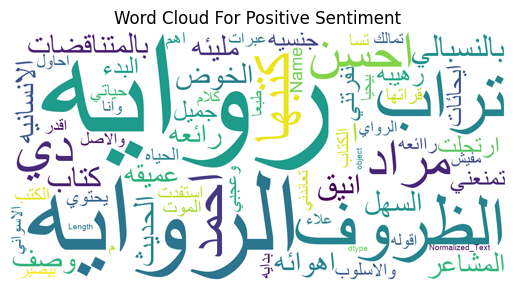

In [17]:
word_cloud_('Positive')

**2-Negative**

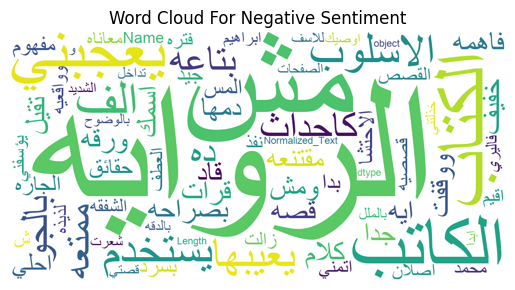

In [18]:
word_cloud_('Negative')

# Most Frequent Words 

In [19]:
MostFrequentWord = Counter((Corpus['Normalized_Text']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7347
1,الكتاب,6617
2,كتاب,3828
3,روايه,3154
4,الكاتب,2793
5,الله,2312
6,اللي,1878
7,مش,1444
8,رائع,1431
9,الاحداث,1247


In [20]:
fig = go.Figure(go.Funnel(
    y = MostFrequentWordDF['Word'].tolist(),
    x = MostFrequentWordDF['Count'].tolist(),
    marker = {"color": color3}))
fig.show()

In [21]:
fig = px.bar(MostFrequentWordDF, y='Word', x='Count',  orientation='h')
fig.show()

# Number Of Words 

In [22]:
Corpus["Number of Words"] = Corpus["Normalized_Text"].apply(lambda n:len(simple_word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

569211

# Number Of Charachters 

In [23]:
Corpus["Number of Charachters"] = Corpus["Normalized_Text"].str.len()
Corpus["Number of Charachters"].sum()

3543446

# Average Number Of Words 

In [24]:
AverageNaumberOfWords = int(np.round((Corpus["Number of Words"].mean())))
AverageNaumberOfWords

35

# Average Number Of Charachters 

In [25]:
AverageNumberOfCharachters = int(np.round(Corpus["Number of Charachters"].mean()))
AverageNumberOfCharachters

216

# Maximum Number Of Word

In [26]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [27]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11593

# Minimum Number Of Words

In [28]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [29]:
MinimumNumberOfCharachters = int(Corpus['Number of Charachters'].mean() )
MinimumNumberOfCharachters

215

# Split The DataSet Into Independent Variables , And Dependent Variable (Y)

In [30]:
X= Corpus['Normalized_Text']
y = Corpus['Sentiment']

# Label Encoder

In [31]:
y = LabelEncoder().fit_transform(y)

# Split The Dataset Into Training And Testing

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=40)

# CountVectorizer

In [33]:
CV = CountVectorizer()
X_train_CV = CV.fit_transform(X_train)
X_test_CV = CV.transform(X_test)

In [34]:
vocab = CV.vocabulary_
vocab

{'تقييمي': 25977,
 'للكتاب': 44489,
 'نجمتين': 51475,
 'ونص': 63644,
 'شاهدت': 33009,
 'المسلسل': 13164,
 'الكتاب': 11587,
 'اسمع': 2928,
 'المدونهالا': 12831,
 'الموقع': 14291,
 'دمه': 30076,
 'خفيف': 29474,
 'اوي': 16365,
 'شربات': 33183,
 'قول': 39245,
 'المصريين': 13312,
 'يضحك': 67151,
 'يبكي': 65164,
 'تعليق': 25362,
 'عجبتني': 35098,
 'مقاله': 49716,
 'الانسان': 5873,
 'يتكلم': 65543,
 'بكلمه': 21083,
 'ويظن': 64568,
 'عادي': 34797,
 'بتاثر': 18753,
 'بقوه': 20973,
 'الكلمات': 11687,
 'الاحيان': 4915,
 'تاثير': 22502,
 'مدمر': 48102,
 'ارزقنا': 2068,
 'بالازواج': 17110,
 'الصالحيين': 9720,
 'بدايه': 19691,
 'قراءتي': 38799,
 'البدايه': 6163,
 'جميله': 27777,
 'اشعر': 3107,
 'افكاره': 4202,
 'مفيده': 49671,
 'مقنعه': 49870,
 'يوتوبيا': 68663,
 'مكرره': 49966,
 'تفتقر': 25573,
 'للعمق': 44341,
 'لمبرر': 44895,
 'الصراع': 9799,
 'الواضح': 14849,
 'سوداويه': 32552,
 'محتمله': 47722,
 'محاوله': 47648,
 'استنساخ': 2710,
 'لعمل': 43018,
 'سابق': 31503,
 'تنبا': 26466,
 'بثوره': 19289,


# Models

In [35]:
def models_(model_name):
    model = model_name
    model.fit(X_train_CV, y_train)
    y_pred = model.predict(X_test_CV)
    return y_pred

# Confusion Matrix

In [36]:
def confusion_matrix_(Real, Prediction):
        ConfusionMatrix = confusion_matrix(Real, Prediction)
        return ConfusionMatrix

# Generate True Positive, False Positive, True Negative, False Negative

In [37]:
def positive_negative(Confusin_Matrix):
    False_Postive = Confusin_Matrix[0, 1]

    True_Positive = Confusin_Matrix[0, 0]

    False_Negative = Confusin_Matrix[1, 0]
    
    True_Negative = Confusin_Matrix[1, 1]

    return False_Postive, True_Positive, False_Negative, True_Negative

# Performance Merics

In [38]:
def performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative):
     Accuracy = (True_Positive + True_Negative) / (True_Positive + True_Negative + False_Postive + False_Negative)
     Precision = True_Positive / (True_Positive+ False_Postive)
     Sensitivity = True_Positive / (True_Positive  + False_Negative)
     Specificity = True_Negative / (True_Negative + False_Negative)
     F1Score = (True_Positive) / ((True_Positive) + (0.5 *(False_Postive + False_Negative)))
     Error = 1 - Accuracy
     MetricsValues = pd.DataFrame(index=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1Score', 'Error'], columns=['Values'], data=[Accuracy, Precision, Sensitivity, Specificity, F1Score, Error])
     return MetricsValues


# Machine Learning

**1. Naive Bayes**

In [39]:
model_name1 = MultinomialNB()
y_pred1 = models_(model_name1)

In [40]:
cm1 = confusion_matrix_(y_test, y_pred1)

In [41]:
False_Postive, True_Positive, False_Negative, True_Negative = positive_negative(cm1)

In [42]:
MetricsValues1 = performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative)

In [43]:
MetricsValues1

,Values
Accuracy,0.888844
Precision,0.915410
Sensitivity,0.863349
Specificity,0.863887
F1Score,0.888618
Error,0.111156


**2. Logistic Regression**

In [44]:
model_name2 = LogisticRegression()
y_pred2 = models_(model_name2)

In [45]:
cm2 = confusion_matrix_(y_test, y_pred2)

In [46]:
False_Postive2, True_Positive2, False_Negative2, True_Negative2 = positive_negative(cm2)
MetricsValues2 = performance_metrics(False_Postive2, True_Positive2, False_Negative2, True_Negative2)
MetricsValues2

,Values
Accuracy,0.897769
Precision,0.901173
Sensitivity,0.889256
Specificity,0.894571
F1Score,0.895175
Error,0.102231


**3. Decision Tree**

In [47]:
model_name3 = DecisionTreeClassifier(criterion = 'entropy')
y_pred3 = models_(model_name3)

In [48]:
cm3 = confusion_matrix_(y_test, y_pred3)

In [49]:
False_Postive3, True_Positive3, False_Negative3, True_Negative3 = positive_negative(cm3)
MetricsValues3 = performance_metrics(False_Postive3, True_Positive3, False_Negative3, True_Negative3)
MetricsValues3

,Values
Accuracy,0.853550
Precision,0.860134
Sensitivity,0.841114
Specificity,0.847364
F1Score,0.850518
Error,0.146450


**4. K Nearest Neighbor**

In [50]:
model_name4 = KNeighborsClassifier(metric='cosine', n_neighbors=5)
y_pred4 = models_(model_name4)

In [51]:
cm4 = confusion_matrix_(y_test, y_pred4)

In [52]:
False_Postive4, True_Positive4, False_Negative4, True_Negative4 = positive_negative(cm4)
MetricsValues4 = performance_metrics(False_Postive4, True_Positive4, False_Negative4, True_Negative4)
MetricsValues4

,Values
Accuracy,0.781744
Precision,0.704355
Sensitivity,0.819688
Specificity,0.854445
F1Score,0.757658
Error,0.218256


**5. Random Forest**

In [53]:
model_name5 = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
y_pred5 = models_(model_name5)

In [54]:
cm5 = confusion_matrix_(y_test, y_pred5)

In [55]:
False_Postive5, True_Positive5, False_Negative5, True_Negative5 = positive_negative(cm5)
MetricsValues5 = performance_metrics(False_Postive5, True_Positive5, False_Negative5, True_Negative5)
MetricsValues5

,Values
Accuracy,0.901014
Precision,0.906198
Sensitivity,0.891269
Specificity,0.896145
F1Score,0.898671
Error,0.098986


**6.SGD Classifier**

In [56]:
model_name6 = SGDClassifier(loss='hinge')
y_pred6 = models_(model_name6)

In [57]:
cm6 = confusion_matrix_(y_test, y_pred6)

In [58]:
False_Postive6, True_Positive6, False_Negative6, True_Negative6 = positive_negative(cm6)
MetricsValues6 = performance_metrics(False_Postive6, True_Positive6, False_Negative6, True_Negative6)
MetricsValues6

,Values
Accuracy,0.901420
Precision,0.892797
Sensitivity,0.902625
Specificity,0.909520
F1Score,0.897684
Error,0.098580


# Deep Learning

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
embedding_dim = 16
vocab_size = len(tokenizer.word_index) + 1

In [60]:
vocab_size

68792

In [61]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length = len(max(X_train_seqs, key=len))

In [62]:
max_length

1853

In [63]:
encoded_X_train = pad_sequences(X_train_seqs, maxlen=max_length)
encoded_X_test = pad_sequences(X_test_seqs, maxlen=max_length)

In [64]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    start_from_epoch=5
                )

**8-Convolutional Neural Network**

In [65]:
model = tf.keras.Sequential([
                Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                Conv1D(filters=32, kernel_size = 3, activation='relu'),
                GlobalAveragePooling1D(),
                Dropout(0.8),
                Dense(1, activation= 'sigmoid')
                ])

In [66]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [67]:
history = model.fit(encoded_X_train, y_train,
                    epochs=50,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/50
873/873 [==============================] - 115s 131ms/step - loss: 0.6924 - accuracy: 0.5212 - val_loss: 0.6874 - val_accuracy: 0.5635
Epoch 2/50
873/873 [==============================] - 77s 88ms/step - loss: 0.6580 - accuracy: 0.6776 - val_loss: 0.6096 - val_accuracy: 0.8199
Epoch 3/50
873/873 [==============================] - 41s 47ms/step - loss: 0.5183 - accuracy: 0.8328 - val_loss: 0.4636 - val_accuracy: 0.8722
Epoch 4/50
873/873 [==============================] - 65s 75ms/step - loss: 0.3624 - accuracy: 0.9008 - val_loss: 0.3675 - val_accuracy: 0.8828
Epoch 5/50
873/873 [==============================] - 66s 75ms/step - loss: 0.2675 - accuracy: 0.9274 - val_loss: 0.3186 - val_accuracy: 0.8888
Epoch 6/50
873/873 [==============================] - 66s 75ms/step - loss: 0.2100 - accuracy: 0.9441 - val_loss: 0.2924 - val_accuracy: 0.8994
Epoch 7/50
873/873 [==============================] - 65s 74ms/step - loss: 0.1718 - accuracy: 0.9555 - val_loss: 0.2781 - val_accurac

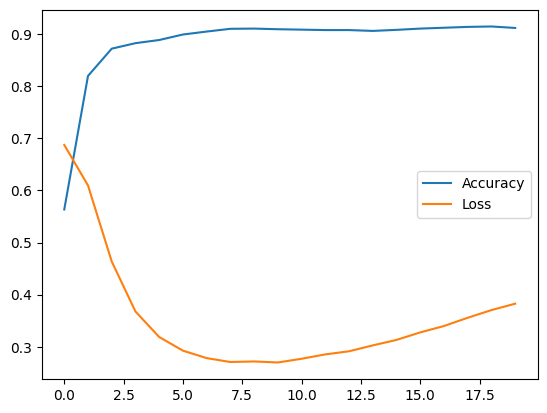

In [68]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

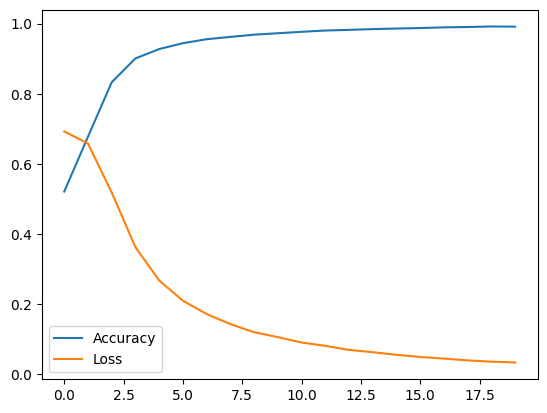

In [69]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [70]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9930
Testing Accuracy:  0.9120


**9-Recurrent Neural Networks**

In [71]:
model = tf.keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(32, return_sequences=False),  
        Dropout(0.2),      
        Dense(1, activation='sigmoid')])

In [72]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [73]:
history = model.fit(encoded_X_train, y_train,
                    epochs=50,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/50
873/873 [==============================] - 125s 140ms/step - loss: 0.4534 - accuracy: 0.7864 - val_loss: 0.2696 - val_accuracy: 0.8917
Epoch 2/50
873/873 [==============================] - 129s 148ms/step - loss: 0.1156 - accuracy: 0.9608 - val_loss: 0.2837 - val_accuracy: 0.9087
Epoch 3/50
873/873 [==============================] - 152s 174ms/step - loss: 0.0395 - accuracy: 0.9863 - val_loss: 0.2976 - val_accuracy: 0.9034
Epoch 4/50
873/873 [==============================] - 129s 147ms/step - loss: 0.0503 - accuracy: 0.9850 - val_loss: 0.3537 - val_accuracy: 0.8970
Epoch 5/50
873/873 [==============================] - 134s 154ms/step - loss: 0.0149 - accuracy: 0.9952 - val_loss: 0.4560 - val_accuracy: 0.8966
Epoch 6/50
873/873 [==============================] - 131s 150ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 0.4499 - val_accuracy: 0.8811
Epoch 7/50
873/873 [==============================] - 141s 162ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.4705 -

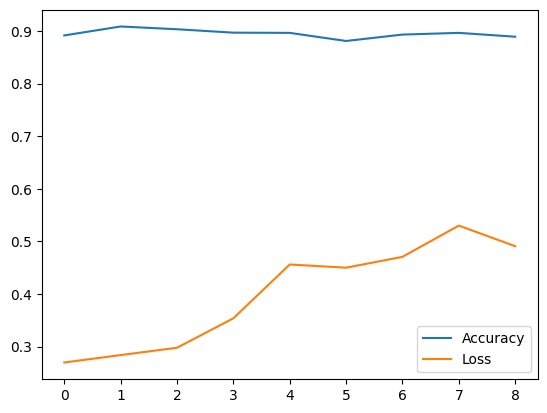

In [74]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

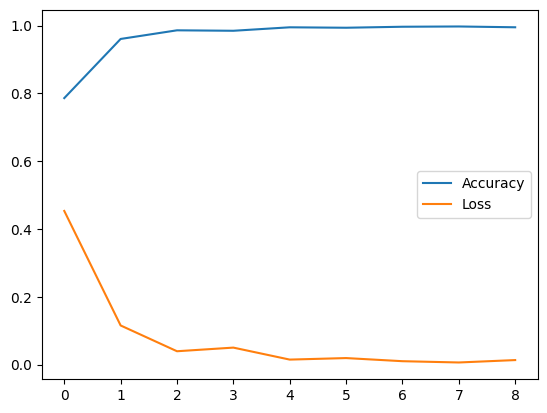

In [75]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [76]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9978
Testing Accuracy:  0.8892
